# Eksploracja danych kongresu amerykańskeigo
W tej prezentacji dokonaliśmy eksploracji ramki danych zamieszczonej pod adresem : https://www.apispreadsheets.com/datasets/121.

Ramka zawiera binarne informacje ('yes' lub 'no') o oddanych głosach przez członków Kongresu Stanów Zjednaczonych Ameryki, oraz jedną kolumnę stwierdzającą przynależność do ugrupowania politycznego (republikańskiego bądź demokratów). Na podstawie oddanych głosów finalnie utworzymy algorytm stierdzający przynależność polityczną bazując swoją wiedzę na kombinacji oddanych głosów.

In [ ]:
# Przygotowanie bibliotek
import pandas as pd
from numpy import array
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [ ]:
# Wgranie ramek danych
raw_df = pd.read_csv("https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/congressional_voting_dataset.csv")
DESCR = pd.read_csv('attributes_congressional_voting.csv')

# Opis ramki
Poniżej zawarta została ramka danych zawierająca informacje o poszczególnych kolumnach oraz jak prezentuje się oryginalna ramka danych:

In [ ]:
DESCR

,name,type,description
0,handicapped_infants,string,Handicapped Infants and Toddlers Act. Values: ...
1,water_project_cost_sharing,string,Water Resources Development Act. Values: y or n
2,adoption_of_the_budget_resolution,string,Omnibus Budget Reconciliation Act of 1986. Val...
3,physician_fee_freeze,string,Medicare Physician Fee Freeze. Values: y or n
4,el_salvador_aid,string,Aid given to El Salvador. Values: y or n
5,religious_groups_in_schools,string,Unknown bill.Values: y or n
6,anti_satellite_test_ban,string,Values: y or n
7,aid_to_nicaraguan_contras,string,Aid given to contras in Nicaragua. Values: y or n
8,mx_missile,string,Decision to retire the MX missile.Values: y or n
9,immigration,string,Immigration Reform and Control Act of 1986. Va...


Dane składają się z 16 kolumn, w które opisują jak dany polityk głosował nad pewnymi kluczowymi ustawami w Kongresie Stanów Zjednoczonych oraz jednej kolumny zawierającej informację o partii tego polityka.

* "y" - polityk głosował za ustawą
* "n" - polityk głosował przeciw ustawie
* "?" - polityk wstrzymał się od głosu lub nie głosował

In [ ]:
raw_df.shape

(435, 17)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   handicapped_infants                     435 non-null    object
 1   water_project_cost_sharing              435 non-null    object
 2   adoption_of_the_budget_resolution       435 non-null    object
 3   physician_fee_freeze                    435 non-null    object
 4   el_salvador_aid                         435 non-null    object
 5   religious_groups_in_schools             435 non-null    object
 6   anti_satellite_test_ban                 435 non-null    object
 7   aid_to_nicaraguan_contras               435 non-null    object
 8   mx_missile                              435 non-null    object
 9   immigration                             435 non-null    object
 10  synfuels_corporation_cutback            435 non-null    object
 11  educat

Nie ma nulli to fajne, ale wszystko ciągi znaków, co mniej fajne.

In [ ]:
raw_df

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y,republican
431,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y,democrat
432,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y,republican
433,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y,republican


Przy przygotowywaniu danych do modelowania najlepiej trzeba będzie przygotować One Hot Encoding, aby uwzględnić wszystkie wartości. Jak się dalej okaże w raporcie, wstrzymanie się od głosu może pomóc w wykryciu partii politycznej, więc lepiej nie marnować informacji. Zwłaszcza, że specyfika zbioru danych może utrudnić zadanie.

In [ ]:
raw_df.describe()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2
top,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y,democrat
freq,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269,267


# Początkowa analiza

Naturalnym punktem startowym jest porównanie liczności partii politycznych.

Republican politians: 168
Democrat politians: 267


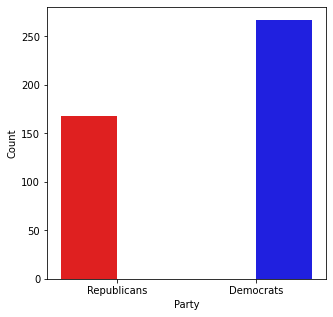

In [ ]:
republicans_count = raw_df[raw_df.political_party == 'republican'].shape[0]
democrats_count = raw_df[raw_df.political_party == 'democrat'].shape[0]
print(f"Republican politians: {republicans_count}")
print(f"Democrat politians: {democrats_count}")

party_count_df = pd.DataFrame({"Party": ["Republicans", "Democrats"], "Count": [republicans_count, democrats_count]})
plt.figure(figsize=(5,5))
p = sns.barplot(data=party_count_df, x="Party", y="Count", hue="Party", palette={"Republicans":"red", "Democrats": "blue"})
p.legend().remove()
plt.show()

Demokraci są u władzy (z przewagą 99 osób), a Republikanie są w opozycji. Być może warto zastanowić się przy podziale zbioru na zbiory treningowe / walidacyjne / testowe nad podzieleniem w proporcjonalny sposób, aby uniknąć sytuacji, w której jeden ze zbiorów jest zdominowany jedną partią.

Jednak nie każdy polityk musi głosować dokładnie tak, jak każe mu partia. Warto więc przyjrzeć się jak osoby z przeciwnych sobie partii głosowały na każdą z ustaw.

In [ ]:
def process(fdf, r_to, r_with):
  d = fdf.copy()
  d.iloc[:, :-1] = d.iloc[:, :-1].replace(r_to, r_with)
  return d[d["political_party"]=="republican"], d[d["political_party"]=="democrat"]

df_yes_r, df_yes_d = process(raw_df, ["y", "n", "?"], [1, 0, 0])
df_no_r, df_no_d = process(raw_df, ["y", "n", "?"], [0, 1, 0])
df_other_r, df_other_d = process(raw_df, ["y", "n", "?"], [0, 0, 1])
df_compare = pd.DataFrame({"Issue": df_yes_r.sum().index,
                           "For (R)": df_yes_r.sum(), 
                           "Against (R)": df_no_r.sum(), 
                           "Other (R)": df_other_r.sum(),
                           "For (D)": df_yes_d.sum(), 
                           "Against (D)": df_no_d.sum(), 
                           "Other (D)": df_other_d.sum()})
df_compare = df_compare.drop("political_party").reset_index(drop=True)
df_compare = df_compare.convert_dtypes()
df_compare

,Issue,For (R),Against (R),Other (R),For (D),Against (D),Other (D)
0,handicapped_infants,31,134,3,156,102,9
1,water_project_cost_sharing,75,73,20,120,119,28
2,adoption_of_the_budget_resolution,22,142,4,231,29,7
3,physician_fee_freeze,163,2,3,14,245,8
4,el_salvador_aid,157,8,3,55,200,12
5,religious_groups_in_schools,149,17,2,123,135,9
6,anti_satellite_test_ban,39,123,6,200,59,8
7,aid_to_nicaraguan_contras,24,133,11,218,45,4
8,mx_missile,19,146,3,188,60,19
9,immigration,92,73,3,124,139,4


Najciekawsze wartości to 82 wstrzymania demokratów w głosowaniu nad ustawą "export_administration_act_south_africa" oraz słabo zarysowane partyjne granice przy ustawie "immigration" i "water_project_cost_sharing". Te ustawy mogą być mniej przydatne w modelu.

Na suche wartości słabo się patrzy, lepiej je umieścić na wykresach.

In [ ]:
# wersja ramki bardziej przyjazna wykresom
df_temp_r = pd.DataFrame({
    "Issue": df_yes_r.sum().index,
    "For votes": df_yes_r.sum(), 
    "Against votes": df_no_r.sum(), 
    "Other votes": df_other_r.sum(),
    "Party": "Republicans"
})
df_temp_r = df_temp_r.drop("political_party").reset_index(drop=True)
df_temp_d = pd.DataFrame({
    "Issue": df_yes_d.sum().index,
    "For votes": df_yes_d.sum(), 
    "Against votes": df_no_d.sum(), 
    "Other votes": df_other_d.sum(),
    "Party": "Democrats"
})
df_temp_d = df_temp_d.drop("political_party").reset_index(drop=True)
df_compare_plot = df_temp_r.append(df_temp_d).reset_index(drop=True)
df_compare_plot = df_compare_plot.melt(id_vars=["Issue", "Party"]).rename(columns={"variable":"Vote type", "value": "Vote count"})

# Rozkłady według partii
Pierwsza rzecz, nad którą warto się zastanowić, to w jaki sposób partie głosowały.


Na początek warto się przyjrzeć jak rokładały się głosy "za" według partii politycznej.

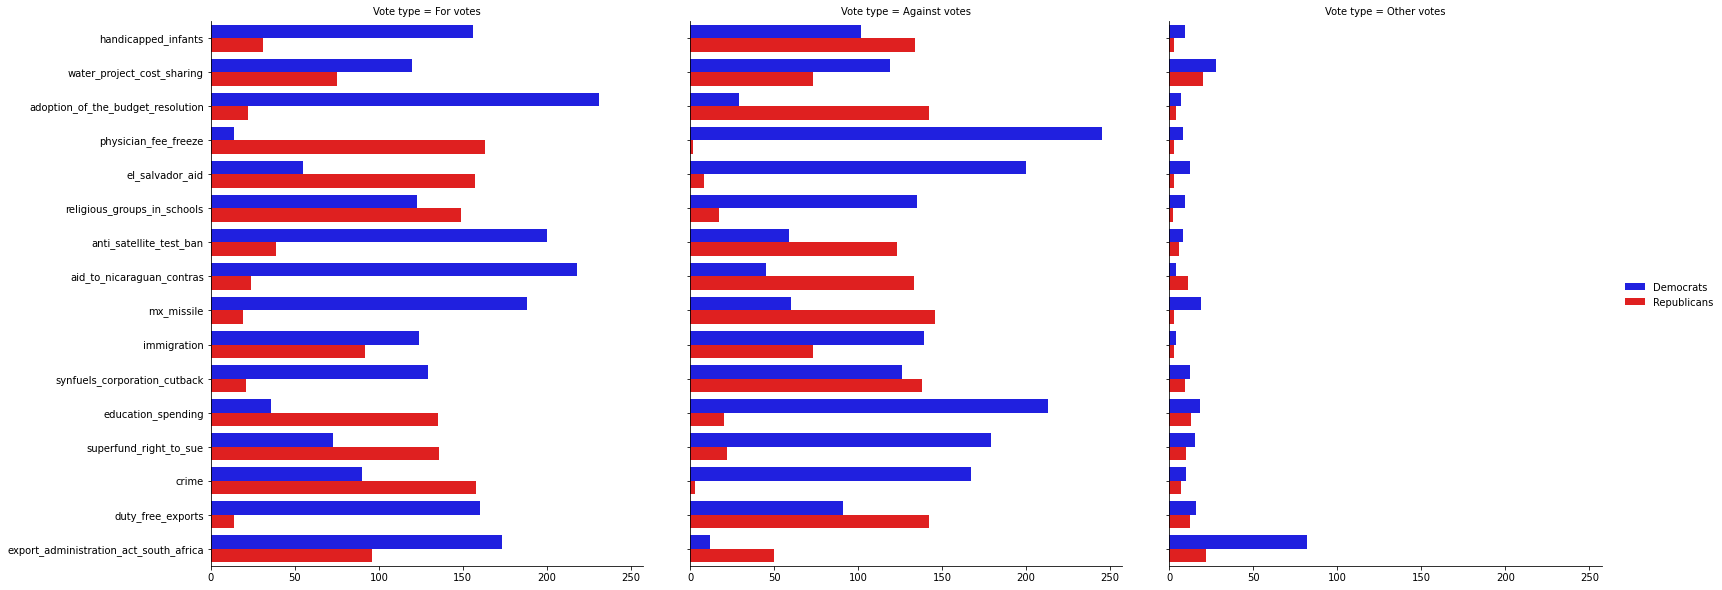

In [ ]:
g = sns.FacetGrid(data=df_compare_plot, col="Vote type")
g.map_dataframe(sns.barplot, x="Vote count", y="Issue", hue="Party", hue_order=["Democrats", "Republicans"], palette={"Republicans":"red", "Democrats": "blue"})
g.fig.set_size_inches(30, 10)
g.add_legend()
plt.show() # nie wiem czy nie rozbić na 3 po prostu, brzydko wygląda tbh

Są spore różnice w wielu miejscach, więc warto przyjrzeć się tym głosom na wykresie punktowym.

# Wykresy punktowe ustaw
Partie są sobie przeciwne, a więc powinniśmy się spodziewać odwrotnej korelacji w głosach "za" i "przeciw", ale co się dzieje ze wstrzymaniami się od głosu?

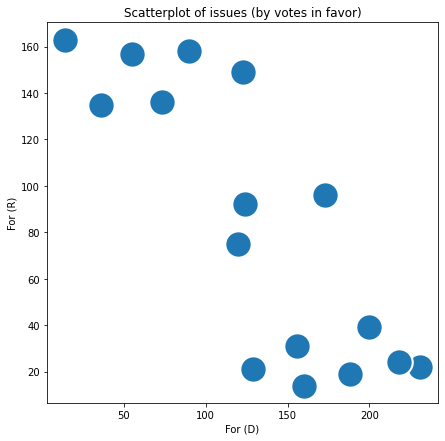

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_compare, x="For (D)", y="For (R)", s=700)
plt.title("Scatterplot of issues (by votes in favor)")
plt.show()

Trzy ustawy znajdujące się na "centrystycznej wyspie" na środku wykresu to są wcześniej zauważone "export_administration_act_south_africa", "immigration" i "water_project_cost_sharing".

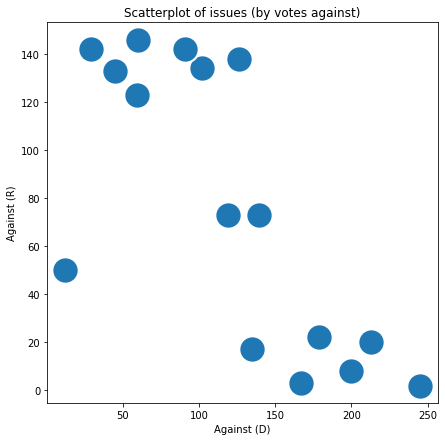

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_compare, x="Against (D)", y="Against (R)", s=700)
plt.title("Scatterplot of issues (by votes against)")
plt.show()

Odstająca wartość w wykresie po głosach przeciw w lewej dolnej części wykresu to ustawa "export_administration_act_south_africa". Już wcześniej zauważyliśmy, że z nią jest dosyć nietypowa.

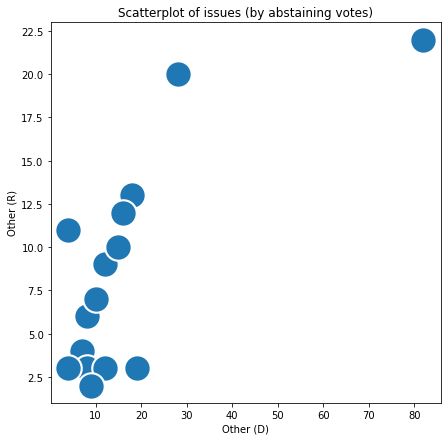

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_compare, x="Other (D)", y="Other (R)", s=700)
plt.title("Scatterplot of issues (by abstaining votes)")
plt.show() 

W przypadku wstrzymania się od głosu wygląda na dodatnią korelację, ale widać, że Demokraci dużo częściej wstrzymują się od głosu od Republikan. Nie potrzeba komentarza, że wartość w prawym górnym rogu to jest ta jedna nietypowa ustawa.

# Różnice pomiędzy partiami

Naszym celem w tym zbiorze danych jest przewidzenie partii polityka, więc warto zobaczyć jak te dwie partie się różnią.




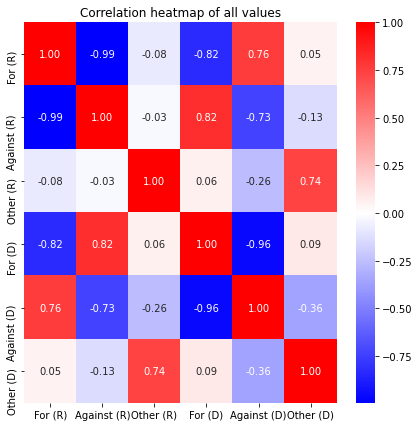

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(df_compare.corr(), annot=True, fmt=".2f", cmap="bwr")
plt.title("Correlation heatmap of all values")
plt.show()

Widać wszystkie korelacje, o których spekulowaliśmy przy wykresach punktowych, ale również charakterystyki wewnątrzpartyjne.

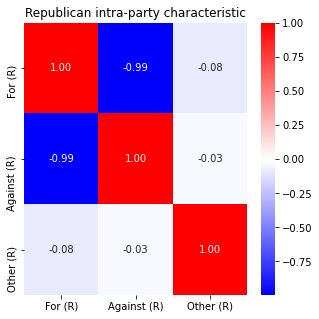

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df_compare.corr().iloc[:3, :3], annot=True, fmt=".2f", cmap="bwr")
plt.title("Republican intra-party characteristic")
plt.show()

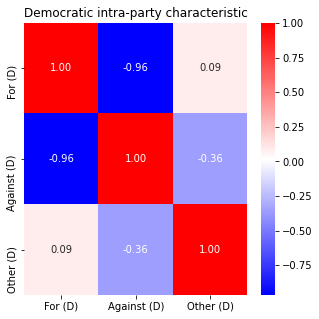

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df_compare.corr().iloc[3:, 3:], annot=True, fmt=".2f", cmap="bwr")
plt.title("Democratic intra-party characteristic")
plt.show()

W charakterystykach wewnątrzpartyjnych warto zauważyć różnicę pomiędzy korelacjami w przypadku głosowań wstrzymujących się.

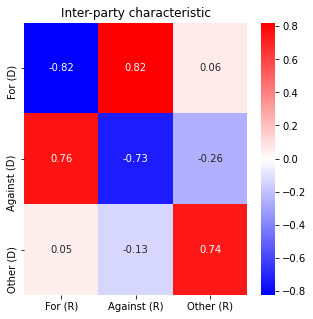

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df_compare.corr().iloc[3:, :3], annot=True, fmt=".2f", cmap="bwr")
plt.title("Inter-party characteristic")
plt.show()

W przypadku międzypartyjnej charakterystyki, otrzymujemy to czego się spodziewaliśmy, czyli odwrotnej 

# Koniec
Zbiór danych jest dosyć nietypowy, co utrudnia analizę, ale również widać wiele zależności, co daje nadzieję na możliwość stworzenia dobrego modelu.